# Andrew Bui

In [854]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import functools
from functools import partial
import seaborn as sns
import plotnine as p9
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from matplotlib.collections import PatchCollection
from matplotlib import cm
from collections import Counter
from matplotlib.patches import Rectangle

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import BaggingClassifier
import shap

import optuna
from optuna.trial import Trial

In [855]:
raw_df = pd.read_pickle("/Users/tb/Downloads/dataset.pkl")  
raw_df

actq      apq        atq       ceqq      cheq  \
date       ticker                                                      
2000-02-01 LLB        3.540    0.143      7.668      6.732     2.553   
2000-02-03 MYR      107.661   24.387    220.463    136.555     1.049   
2000-02-08 LZB      447.719   57.893    740.905    460.612    16.531   
           SJM      234.415   33.821    488.136    322.432    26.054   
2000-02-09 CSCO    7722.000  482.000  21391.000  16523.000  3968.000   
...                     ...      ...        ...        ...       ...   
2018-12-31 ELLO      77.786    1.907    255.123     90.949    61.530   
           MFCB      84.040   20.586    252.126    186.153    59.330   
           MFCB      79.628   16.437    242.757    193.929    56.640   
           PETZ      13.670    6.395     18.833      6.459     2.524   
           SGOC      15.429    0.088    156.187     98.344     5.608   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-01 LLB        0.458     6.3910     6.391     6.989     0.0  ...   
2000-02-03 MYR       36.883    25.5360    22.082    28.458     0.0  ...   
2000-02-08 LZB      274.525    52.2660    52.274    52.544     0.0  ...   
           SJM       91.172    28.8808    28.603    32.425     0.0  ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   
...                     ...        ...       ...       ...     ...  ...   
2018-12-31 ELLO       2.272    10.9220    10.676       NaN     0.0  ...   
           MFCB      76.382    12.5350    12.535    12.600     0.0  ...   
           MFCB       4.650    12.5350    12.535    12.600     0.0  ...   
           PETZ      12.253     9.3245     9.424     9.424     0.0  ...   
           SGOC       0.712    15.6510    18.931    24.844     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  1   
           MFCB                    0                  0                  1   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   
...                              ...                ...                ...   
2018-12-31 ELLO                    0                  0                  0   
           MFCB                    0                  0                  0   
           MFCB                    0                  0                  0   
           PETZ                    0                  0                  0   
           SGOC                    0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
da

In [856]:
raw_df['pred_rel_return']

date        ticker
2000-02-01  LLB      -0.520952
2000-02-03  MYR       0.109669
2000-02-08  LZB       0.091725
            SJM       0.121184
2000-02-09  CSCO     -0.025923
                        ...   
2018-12-31  ELLO           NaN
            MFCB      0.000000
            MFCB           NaN
            PETZ           NaN
            SGOC           NaN
Name: pred_rel_return, Length: 294412, dtype: float64

In [857]:
#### The entries are 1 if the stock outperforms SPY by more than 5% in the earnings period and -1 if it underperforms by -10% and 0 if the performance is between these values.

In [858]:
# raw_df.loc[raw_df['pred_rel_return'] <= 0, 'outpf'] = 0
# raw_df.loc[raw_df['pred_rel_return'] > 0, 'outpf'] = 1
# raw_df['outpf']

def f(x):
    if x > 0.05:
        return 1
    elif x < -0.1:
        return -1
    else:
        return 0
    
data = raw_df.copy()
data['rel_outpf'] = data['pred_rel_return'].apply(f)
data['rel_outpf']


date        ticker
2000-02-01  LLB      -1
2000-02-03  MYR       1
2000-02-08  LZB       1
            SJM       1
2000-02-09  CSCO      0
                     ..
2018-12-31  ELLO      0
            MFCB      0
            MFCB      0
            PETZ      0
            SGOC      0
Name: rel_outpf, Length: 294412, dtype: int64

In [859]:
data.replace([np.inf,-np.inf],np.nan,inplace=True)
data = data.fillna(method='ffill')
data = data.fillna(0)

In [860]:
#### 2 if the stock return is more then 5% higher than the SPY return, 1 if it is more than 1% but less than 5% higher, 0 if it is between -1% and 1%, 
#### -2 if the stock underperforms the SPY by more than -5% and -1 if the performance is between -1% and -5%

In [861]:
# raw_df.loc[raw_df['pred_rel_return'] > 0.05, 'outpf_dt'] = 2
# raw_df.loc[(raw_df['pred_rel_return'] > 0.01) & (raw_df['pred_rel_return'] <= 0.05), 'outpf_dt'] = 1
# raw_df.loc[(raw_df['pred_rel_return'] > -0.01) & (raw_df['pred_rel_return'] <= 0.01), 'outpf_dt'] = 0
# raw_df.loc[(raw_df['pred_rel_return'] > -0.05) & (raw_df['pred_rel_return'] <= -0.01), 'outpf_dt'] = -1
# raw_df.loc[raw_df['pred_rel_return'] <= -0.05, 'outpf_dt'] = -2

def f1(x):
    if x > 0.05:
        return 2
    elif 0.01 < x <= 0.05:
        return 1
    elif -0.01 < x <= 0.01:
        return 0
    elif -0.05 < x <= -0.01:
        return -1
    elif x < -0.05:
        return -2
    else:
        return 0
    
data['rel_outpf_dt'] = data['pred_rel_return'].apply(f1)
data['rel_outpf_dt']

date        ticker
2000-02-01  LLB      -2
2000-02-03  MYR       2
2000-02-08  LZB       2
            SJM       2
2000-02-09  CSCO     -1
                     ..
2018-12-31  ELLO      0
            MFCB      0
            MFCB      0
            PETZ      0
            SGOC      0
Name: rel_outpf_dt, Length: 294412, dtype: int64

In [862]:
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [863]:
df_train = data.loc['2007-01-01':'2009-12-31']
df_valid = data.loc['2010-04-01':'2010-07-01']
df_test = data.loc['2010-01-01':'2018-12-31']


In [864]:
train = df_train.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                    'spy_next_period_return',
                                    'rel_outpf','pred_rel_return',
                                    'rel_outpf_dt','return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                    'spy_next_period_return',
                                    'rel_outpf','pred_rel_return',
                                    'rel_outpf_dt','return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                    'next_period_return',
                                    'spy_next_period_return',
                                    'rel_outpf','pred_rel_return',
                                    'rel_outpf_dt','return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [865]:
train_stock_returns = df_train['next_period_return']
valid_stock_returns = df_valid['next_period_return']
test_stock_returns = df_test['next_period_return']

train_stock_returns

date
2007-01-04   -0.312268
2007-01-04    0.357608
2007-01-04    0.231287
2007-01-04   -0.166167
2007-01-04    0.014049
                ...   
2009-12-30   -0.048857
2009-12-30   -0.779047
2009-12-30   -0.068118
2009-12-30    0.486751
2009-12-30   -0.082777
Name: next_period_return, Length: 46632, dtype: float64

In [866]:
y_train = df_train['rel_outpf'].values
y_valid = df_valid['rel_outpf'].values
y_test = df_test['rel_outpf'].values

Counter(y_test)

Counter({1: 50585, 0: 65805, -1: 32744})

In [867]:
scaler = StandardScaler()
float_vars = [x for x in train.columns if data[x].dtype == 'float64']
len(float_vars)

179

In [868]:
train_norm = train.copy()
valid_norm = valid.copy()
test_norm = test.copy()

In [869]:
# train_norm = train_norm.replace((np.inf, -np.inf, np.nan), 0.).reset_index(drop=True)
# valid_norm = valid_norm.replace((np.inf, -np.inf, np.nan), 0.).reset_index(drop=True)
# test_norm = test_norm.replace((np.inf, -np.inf, np.nan), 0.).reset_index(drop=True)

In [870]:
train_norm[float_vars] = scaler.fit_transform(train_norm[float_vars])
valid_norm[float_vars] = scaler.transform(valid_norm[float_vars])
test_norm[float_vars] = scaler.transform(test_norm[float_vars])

In [871]:
test_norm[float_vars]

,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,cshopq,...,inv_turnq,at_turnq,rect_turnq,pay_turnq,sale_invcapq,sale_equityq,sale_nwcq,rd_saleq,at5,accrualq
0,-0.279890,-0.079459,-0.111564,-0.233171,-0.081250,-0.189912,-0.278328,-0.278055,-0.262095,-0.120784,...,-0.047425,1.125701,0.160023,0.009069,-0.002558,0.021137,0.083831,-0.018163,-0.114751,-0.063510
1,-0.271772,-0.079489,-0.110701,-0.226176,-0.081496,-0.171975,-0.252788,-0.252804,-0.243280,-0.120784,...,-0.049647,1.664879,-0.018252,0.014526,0.000644,0.021580,0.033377,-0.018163,-0.113692,-0.062268
2,-0.263434,-0.078451,-0.109955,-0.227455,-0.080859,-0.176175,-0.238488,-0.237489,-0.229817,-0.120620,...,-0.061046,-0.228423,-0.029103,0.007487,-0.006579,-0.008684,-0.002196,-0.018163,-0.112881,-0.049791
3,-0.251433,-0.079328,-0.107964,-0.186659,-0.076644,-0.187178,-0.232525,-0.232659,-0.224932,-0.120784,...,-0.077226,-0.333036,-0.021458,0.009235,-0.007331,-0.023620,-0.006675,-0.017868,-0.110935,-0.060145
4,-0.262452,-0.079140,-0.110343,-0.218375,-0.077039,-0.177526,-0.228746,-0.228793,-0.221637,-0.120784,...,-0.038410,0.662380,-0.013981,0.009554,-0.004168,-0.009914,-0.003187,-0.018110,-0.113496,-0.063662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149129,-0.266117,-0.079508,-0.109432,-0.223451,-0.077473,-0.192919,-0.259951,-0.260558,-0.262017,-0.120784,...,-0.077668,-0.801078,-0.030846,0.007080,-0.008543,-0.027870,-0.010036,-0.018163,-0.112622,-0.062412
149130,-0.264873,-0.079014,-0.109461,-0.211364,-0.077619,-0.170313,-0.256677,-0.256868,-0.246758,-0.120784,...,-0.077668,-0.801078,-0.030846,0.007080,-0.008543,-0.027870,-0.010036,-0.018163,-0.111443,-0.062412
149131,-0.265751,-0.079124,-0.109551,-0.210377,-0.077797,-0.192194,-0.256677,-0.256868,-0.246758,-0.120784,...,-0.077668,-0.801078,-0.030846,0.007080,-0.008543,-0.027870,-0.010036,-0.018163,-0.111772,-0.062412
149132,-0.278867,-0.079389,-0.111705,-0.234178,-0.081386,-0.189875,-0.263193,-0.263044,-0.252555,-0.120784,...,-0.077668,-0.801078,-0.030846,0.007080,-0.008543,-0.027870,-0.010036,-0.018163,-0.115000,-0.062412


In [872]:
t_clf = DecisionTreeClassifier(min_samples_leaf = 100,max_depth=15)

In [873]:
bg_clf = BaggingClassifier(t_clf,n_estimators=40, random_state=123,n_jobs=-1)

In [874]:
t_clf.fit(train_norm,y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=100)

In [875]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=100),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [876]:
accuracy_score(y_train,t_clf.predict(train_norm))

0.5057256819351518

In [877]:
accuracy_score(y_valid,t_clf.predict(valid_norm))

0.3699624530663329

In [878]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    t_clf.fit(train,labels)

    preds = t_clf.predict(val)
    profit = (preds * val_rets).sum()

    return profit

In [879]:
study = optuna.create_study(direction="maximize")

[I 2023-01-30 00:10:10,676] A new study created in memory with name: no-name-2a17ce59-66bc-4df6-b7ae-add0bcd767af


In [880]:
%%time
study.optimize(partial(objective,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=100,n_jobs=-1)

[I 2023-01-30 00:10:18,902] Trial 0 finished with value: -137.8076300000001 and parameters: {'min_samples_leaf': 400, 'max_depth': 5}. Best is trial 0 with value: -137.8076300000001.
[I 2023-01-30 00:10:19,719] Trial 7 finished with value: -113.89272100000004 and parameters: {'min_samples_leaf': 800, 'max_depth': 5}. Best is trial 7 with value: -113.89272100000004.
[I 2023-01-30 00:10:19,939] Trial 9 finished with value: -137.8076300000001 and parameters: {'min_samples_leaf': 500, 'max_depth': 5}. Best is trial 7 with value: -113.89272100000004.
[I 2023-01-30 00:10:20,263] Trial 8 finished with value: -126.73980900000001 and parameters: {'min_samples_leaf': 1200, 'max_depth': 10}. Best is trial 7 with value: -113.89272100000004.
[I 2023-01-30 00:10:21,017] Trial 6 finished with value: -128.96783800000003 and parameters: {'min_samples_leaf': 1000, 'max_depth': 25}. Best is trial 7 with value: -113.89272100000004.
[I 2023-01-30 00:10:21,438] Trial 1 finished with value: -123.710523000000

CPU times: user 23min 58s, sys: 17.4 s, total: 24min 15s
Wall time: 2min 29s


In [881]:
study.best_params

{'min_samples_leaf': 100, 'max_depth': 20}

In [882]:
## Instantiating the classifier with hyper-parameters

In [883]:
t_clf1 = DecisionTreeClassifier(**study.best_params,random_state=123)


In [884]:
t_clf1.fit(train_norm,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=123)

In [885]:
t_clf1.score(train_norm,y_train)

0.5099716932578486

In [886]:
t_clf1.score(valid_norm,y_valid)

0.3659574468085106

In [887]:
pred_valid = t_clf1.predict(valid_norm)

In [888]:
Counter(pred_valid)

Counter({0: 1425, -1: 389, 1: 2181})

In [889]:
confusion_matrix(pred_valid,y_valid)

array([[118, 146, 125],
       [294, 579, 552],
       [563, 853, 765]])

In [890]:
#### Pick the importance features

In [891]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [892]:
fi = tree_feat_importance(t_clf1,train_norm)
fi

,cols,feat_imp
87,prccq,0.111219
105,cf_yield,0.046823
89,bmq,0.042790
108,dprq,0.040845
180,fqtr_2,0.032438
...,...,...
329,sic_3533,0.000000
330,sic_3537,0.000000
331,sic_3540,0.000000
332,sic_3541,0.000000


In [893]:
features = fi[(fi['feat_imp'] > 0.002)]
features

,cols,feat_imp
87,prccq,0.111219
105,cf_yield,0.046823
89,bmq,0.042790
108,dprq,0.040845
180,fqtr_2,0.032438
...,...,...
6,csh12q,0.002167
91,book_value_yield,0.002157
51,revtq,0.002126
78,oibdpy,0.002068


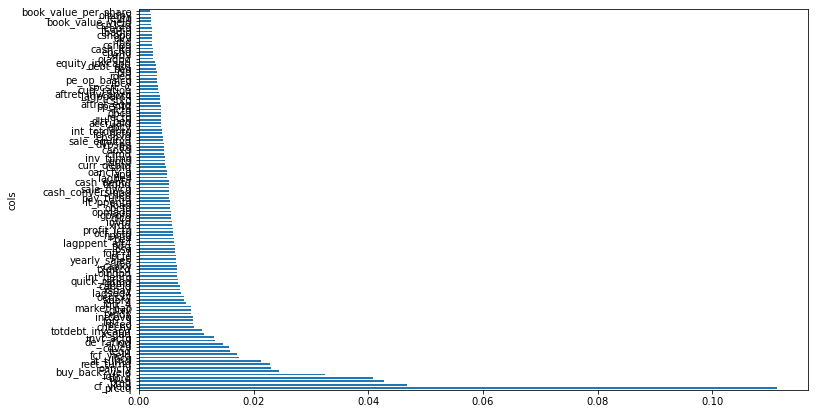

In [894]:
plot_fi(features);

In [895]:
cols = features['cols'].values
cols

array(['prccq', 'cf_yield', 'bmq', 'dprq', 'fqtr_2', 'buy_back_yield',
       'oancfy', 'rect_turnq', 'at_turnq', 'ibcq', 'fcf_yield', 'teqq',
       'cdvcy', 'niq', 'de_ratioq', 'invt_actq', 'xsgaq',
       'totdebt_invcapq', 'chechy', 'roceq', 'fqtr_3', 'intcovq', 'txpdy',
       'dltry', 'market_cap', 'fqtr_4', 'xoprq', 'oepsxy', 'lagseq4',
       'xsgay', 'capeiq', 'gpmq', 'quick_ratioq', 'int_debtq', 'oibdpq',
       'txditcq', 'capxy', 'req', 'yearly_sales', 'pcfq', 'fqtr_1', 'psq',
       'txtq', 'lagppent_alt4', 'be4', 'npmq', 'ocf_lctq', 'profit_lctq',
       'xrdq', 'invtq', 'dlcq', 'gprofq', 'opmadq', 'opcfq', 'roaq',
       'lt_ppentq', 'pay_turnq', 'cheq', 'cash_conversionq', 'sale_nwcq',
       'txdbq', 'cash_debtq', 'lagbe4', 'apq', 'oancfy_q', 'cshiq',
       'curr_debtq', 'xintq', 'inv_turnq', 'cfmq', 'capxq', 'ltq',
       'dvpspq', 'sale_equityq', 'epspxq', 'fcf_ocfq', 'int_totdebtq',
       'dpcy', 'accrualq', 'dltt_beq', 'rectq', 'dpcq', 'lctq', 'ppentq',
       'a

In [896]:
## Retest with reduced number of features

In [897]:
train_red = pd.DataFrame(data = scaler.fit_transform(train_norm[cols].values),columns = cols)
valid_red = pd.DataFrame(data = scaler.transform(valid_norm[cols].values),columns = cols)
test_red = pd.DataFrame(data = scaler.transform(test_norm[cols].values),columns = cols)

In [898]:
t_clf1.fit(train_red,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=123)

In [899]:
t_clf1.score(train_red,y_train)

0.5085349116486533

In [900]:
t_clf1.score(valid_red,y_valid)

0.365206508135169

In [901]:
t_clf1.feature_names_in_

array(['prccq', 'cf_yield', 'bmq', 'dprq', 'fqtr_2', 'buy_back_yield',
       'oancfy', 'rect_turnq', 'at_turnq', 'ibcq', 'fcf_yield', 'teqq',
       'cdvcy', 'niq', 'de_ratioq', 'invt_actq', 'xsgaq',
       'totdebt_invcapq', 'chechy', 'roceq', 'fqtr_3', 'intcovq', 'txpdy',
       'dltry', 'market_cap', 'fqtr_4', 'xoprq', 'oepsxy', 'lagseq4',
       'xsgay', 'capeiq', 'gpmq', 'quick_ratioq', 'int_debtq', 'oibdpq',
       'txditcq', 'capxy', 'req', 'yearly_sales', 'pcfq', 'fqtr_1', 'psq',
       'txtq', 'lagppent_alt4', 'be4', 'npmq', 'ocf_lctq', 'profit_lctq',
       'xrdq', 'invtq', 'dlcq', 'gprofq', 'opmadq', 'opcfq', 'roaq',
       'lt_ppentq', 'pay_turnq', 'cheq', 'cash_conversionq', 'sale_nwcq',
       'txdbq', 'cash_debtq', 'lagbe4', 'apq', 'oancfy_q', 'cshiq',
       'curr_debtq', 'xintq', 'inv_turnq', 'cfmq', 'capxq', 'ltq',
       'dvpspq', 'sale_equityq', 'epspxq', 'fcf_ocfq', 'int_totdebtq',
       'dpcy', 'accrualq', 'dltt_beq', 'rectq', 'dpcq', 'lctq', 'ppentq',
       'a

In [902]:
pred_valid = t_clf1.predict(valid_red)

In [903]:
Counter(y_valid)

Counter({-1: 975, 0: 1578, 1: 1442})

In [904]:
Counter(pred_valid)

Counter({0: 1449, -1: 405, 1: 2141})

In [905]:
confusion_matrix(y_valid,pred_valid)

array([[123, 285, 567],
       [150, 595, 833],
       [132, 569, 741]])

In [906]:
profit = (pred_valid * df_valid['next_period_return'].values).sum()
profit

-64.2796030000001

In [907]:
valid_1 = valid_red.copy()

valid_1['rets'] = df_valid['next_period_return'].values

valid_1.head()

,prccq,cf_yield,bmq,dprq,fqtr_2,buy_back_yield,oancfy,rect_turnq,at_turnq,ibcq,...,dvy,cshopq,ibadjq,icaptq,csh12q,book_value_yield,revtq,oibdpy,book_value_per_share,rets
0,-0.522484,-0.014004,-0.132379,-0.013217,-0.579397,-1.116485,-0.094303,-0.020626,-0.257246,-0.073997,...,-0.158291,-0.120784,-0.070813,-0.174337,-0.264818,-0.137062,-0.237311,-0.174023,-0.390475,-0.336472
1,-0.387854,0.005725,0.331829,-0.013217,-0.579397,0.303131,-0.093137,-0.024949,0.370006,-0.088494,...,-0.158291,-0.061416,-0.087239,-0.170178,-0.258725,0.427022,-0.227459,-0.167435,-0.096939,-0.053734
2,-0.555003,-0.151560,0.380957,-0.013217,-0.579397,0.716013,-0.096201,-0.029706,-0.310122,-0.077906,...,-0.158291,-0.117321,-0.073956,-0.173873,-0.264441,0.378733,-0.237016,-0.167435,-0.385095,0.046354
3,-0.165510,-0.000045,0.226304,-0.013217,-0.579397,0.716013,-0.087027,-0.021462,-0.336852,-0.071536,...,-0.158291,-0.120784,-0.068025,-0.157011,-0.232393,0.220128,-0.226046,-0.161692,0.133683,0.008899
4,-0.112658,0.022619,-0.338500,-0.013217,-0.579397,0.716013,-0.072064,0.011701,0.187644,-0.108683,...,-0.158291,-0.120784,-0.110229,-0.163405,-0.212705,-0.298931,-0.209365,-0.155000,-0.215134,-0.015186


In [908]:
pred = t_clf1.predict(valid_red)
(pred*valid_1[valid_1.columns[-1]].values).sum()

-64.2796030000001

In [909]:
## Calculating the Shapley values

In [910]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = t_clf1.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [911]:
explainer = shap.explainers.Permutation(model,valid_1)

In [912]:
shap_values = explainer(valid_1,max_evals=2000)

Permutation explainer: 3996it [14:42,  4.48it/s]                          


In [913]:
shap_values.values.shape

(3995, 113)

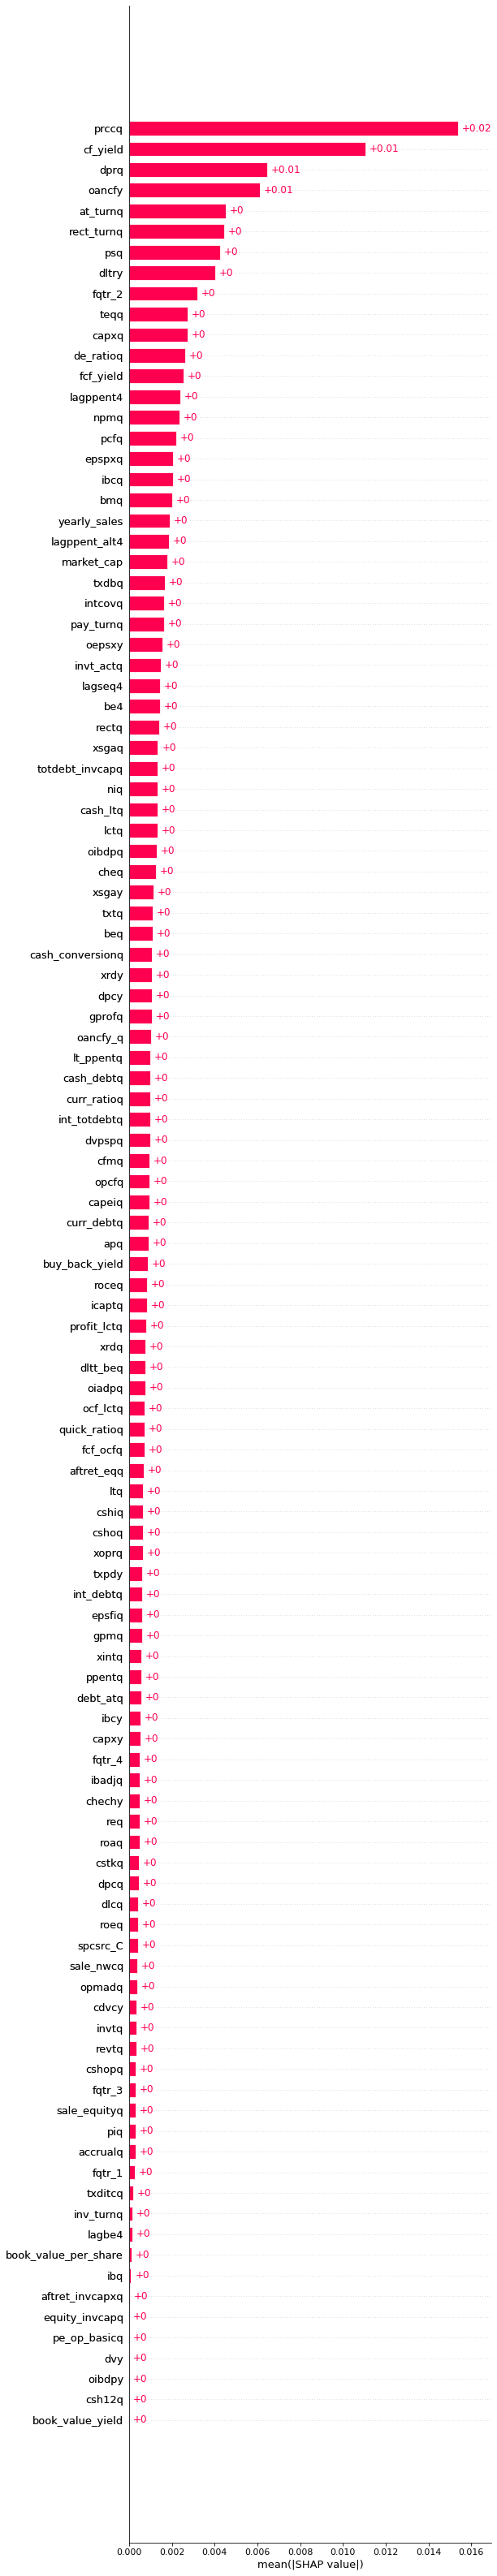

In [914]:
shap.plots.bar(shap_values[:,:-1],max_display=120)

In [915]:
shap_cols = ['prccq', 'cf_yield', 'bmq', 'dprq', 'fqtr_2', 'buy_back_yield',
       'oancfy', 'rect_turnq', 'at_turnq', 'ibcq', 'fcf_yield', 'teqq',
       'cdvcy', 'niq', 'de_ratioq', 'invt_actq', 'xsgaq',
       'totdebt_invcapq', 'chechy', 'roceq', 'fqtr_3', 'intcovq', 'txpdy',
       'dltry', 'market_cap', 'fqtr_4', 'xoprq', 'oepsxy', 'lagseq4',
       'xsgay', 'capeiq', 'gpmq', 'quick_ratioq', 'int_debtq', 'oibdpq',
       'txditcq', 'capxy', 'req', 'yearly_sales', 'pcfq', 'fqtr_1', 'psq',
       'txtq', 'lagppent_alt4', 'be4', 'npmq', 'ocf_lctq', 'profit_lctq',
       'xrdq', 'invtq', 'dlcq', 'gprofq', 'opmadq', 'opcfq', 'roaq',
       'lt_ppentq', 'pay_turnq', 'cheq', 'cash_conversionq', 'sale_nwcq',
       'txdbq', 'cash_debtq', 'lagbe4', 'apq', 'oancfy_q', 'cshiq',
       'curr_debtq', 'xintq', 'inv_turnq', 'cfmq', 'capxq', 'ltq',
       'dvpspq', 'sale_equityq', 'epspxq', 'fcf_ocfq', 'int_totdebtq',
       'dpcy', 'accrualq', 'dltt_beq', 'rectq', 'dpcq', 'lctq', 'ppentq',
       'aftret_eqq', 'cstkq', 'lagppent4', 
       'curr_ratioq', 'spcsrc_C', 'ibcy',  'roeq', 'piq',
       'beq', 'debt_atq',  'oiadpq', 'xrdy', 'epsfiq',
       'cash_ltq', 'cshoq', 'ibq',  'cshopq', 'ibadjq', 'icaptq',
        'revtq', 'book_value_per_share']

In [916]:
len(shap_cols)

105

In [917]:
len(valid_1.columns[:-1])

112

In [918]:
shap_values[:,:-1].values.shape

(3995, 112)

In [919]:
len(valid_1.columns[:-1])

112

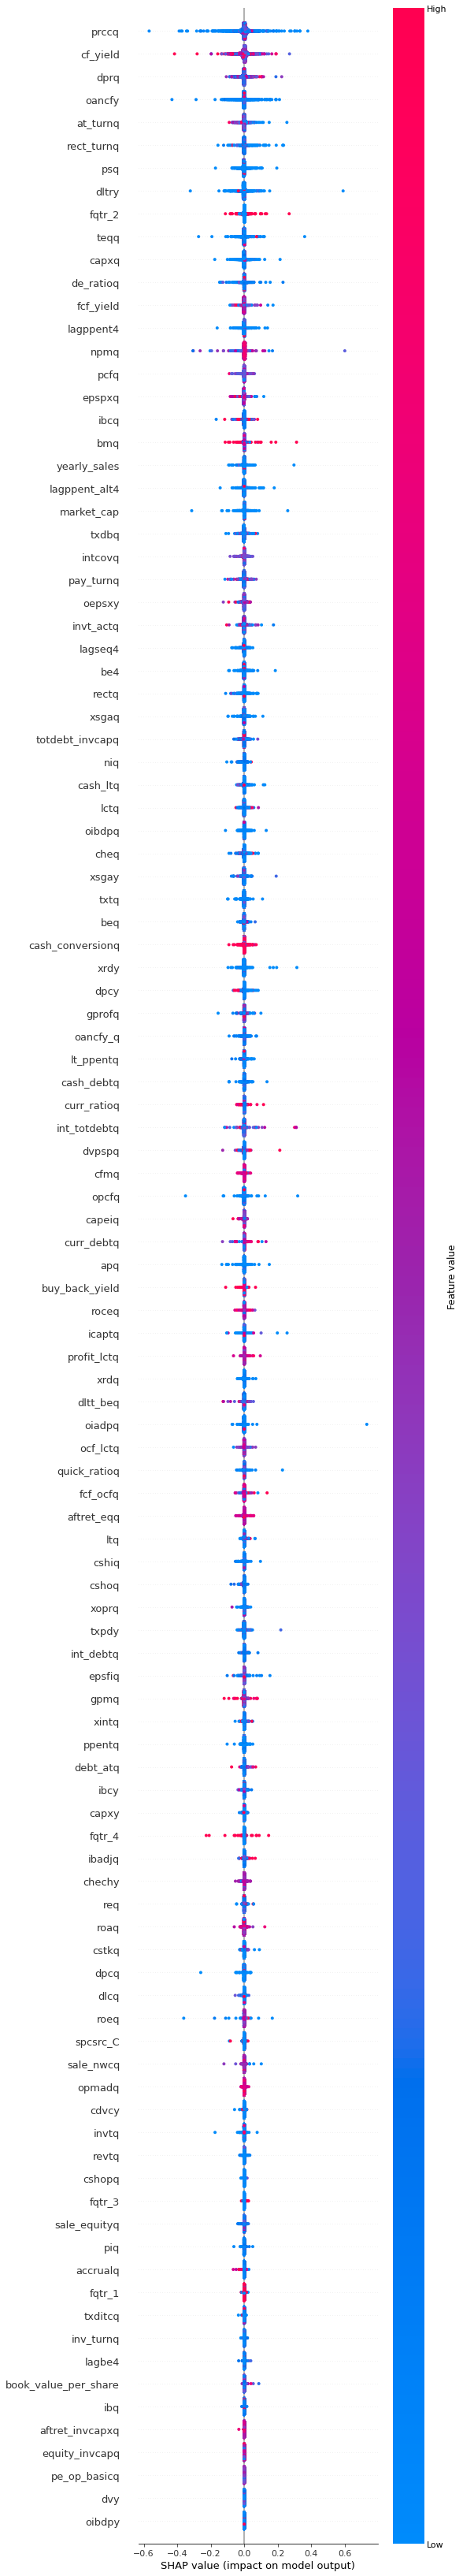

In [920]:
shap.summary_plot(shap_values[:,:-1], features=valid_1[valid_1.columns[:-1]],max_display=110)

In [921]:
valid_1 = valid[cols].copy()
valid_1['rets'] = df_valid['next_period_return'].values

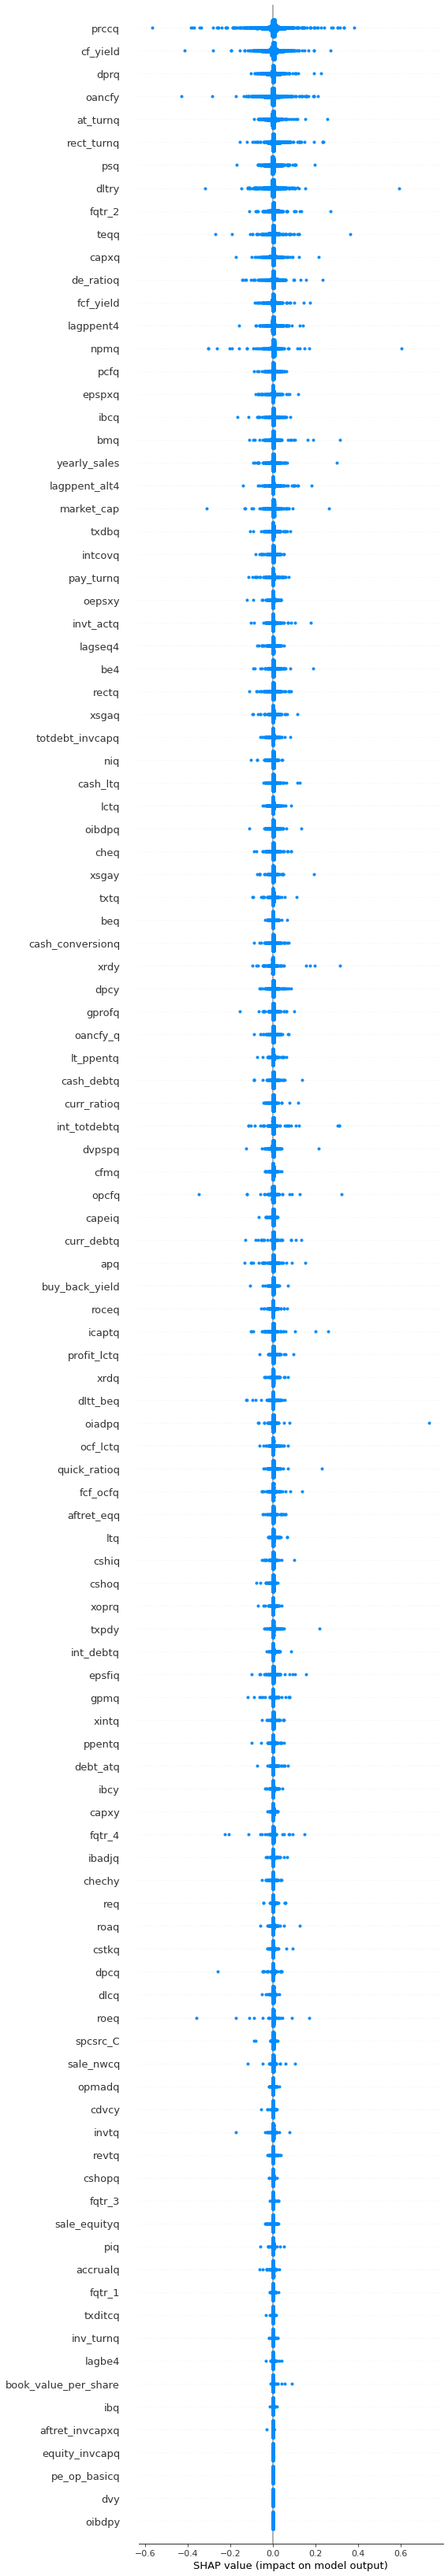

In [922]:
shap.summary_plot(shap_values[:,:-1], features=list(valid_1.columns), class_inds=[2], max_display=110)

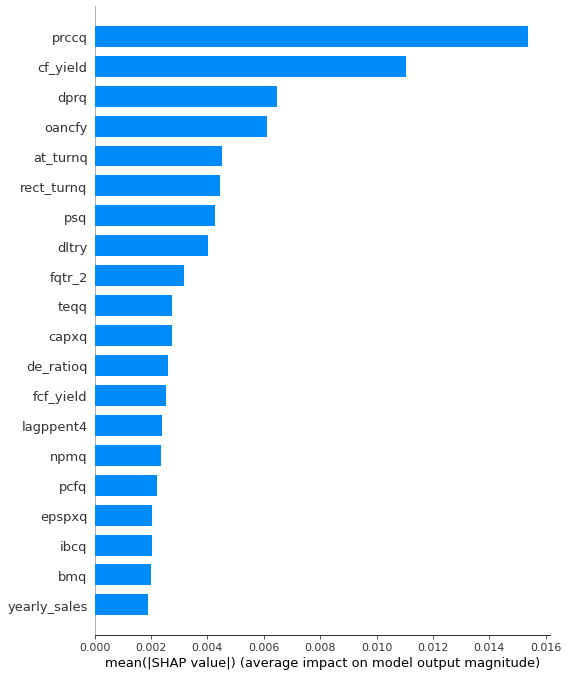

In [923]:
shap.summary_plot(shap_values[:,:-1], valid_1[valid_1.columns[:-1]], plot_type="bar")

In [924]:
### Perform on test set

In [925]:
t_clf1 = DecisionTreeClassifier(**study.best_params,random_state=123)

In [926]:
t_clf1.fit(train_norm[shap_cols],y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=123)

In [927]:
test_set = test_red[shap_cols]
pred_test = t_clf1.predict(test_set)
# pred_test_avr = pred_test_avr/np.abs(pred_test_avr).sum()
Test_P_L = (pred_test * df_test['next_period_return']).sum()
Test_P_L

2829.434058

In [928]:
valid_set = valid_red[shap_cols]
pred_test = t_clf1.predict(valid_set)
valid_P_L = (pred_test * df_valid['next_period_return']).sum()
valid_P_L


-65.30732000000009

In [929]:
Act_P_L = (y_test * df_test['pred_rel_return']).sum()
Act_P_L 

18113.265225999996

If we were 100% correct on the test set we would get the profit of 18113 but instead the model only able to get 2829.

In [930]:
## Long Short Strategy

In [931]:
LS_predictions = []
LS_predictions.append((df_test['rel_outpf'] * df_test['next_period_return']).sum())

In [932]:
random_predictions

[18999.952275]

In [933]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3*i) for i in range(32)]
end_dates = [d + pd.DateOffset(months = 11) for d in start_dates]

In [934]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 32)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [935]:
training_data = [d.reset_index() for d in training_frames]
test_data = [d.reset_index() for d in test_frames]
training_labels = [d['rel_outpf'].values for d in training_frames]

In [936]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [937]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

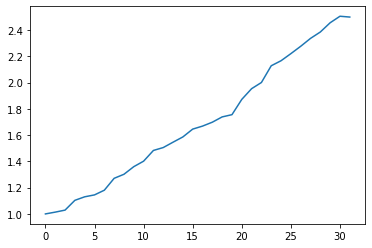

In [938]:
plt.plot(x);

###Compare with SPY

In [939]:
SPY = pd.read_pickle(r'/Users/tb/Downloads/SPY_cum_ret.pkl')
SPY = SPY.loc['2010-01-01':'2017-12-31']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0]+1)
SPY['strategy'] = x

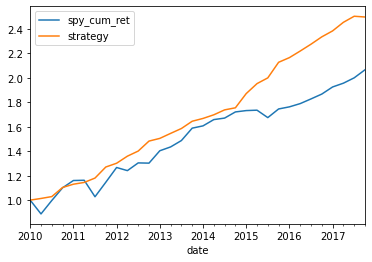

In [940]:
SPY.plot();

In [941]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sharpe = strategy_mean_ret/strategy_std
strategy_std

0.029897401021451404

In [942]:
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
spy_sharpe = spy_mean_ret/spy_std
spy_std

0.05981429259002538

In [943]:
strat_ret = x[-1]
SPY_ret = SPY['spy_cum_ret'][-1]


In [944]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [945]:
beta_strat = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta_strat

0.0447515148255901

In [946]:
residual_ret = strategy_ret - beta_strat * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

1.5968456154326975

In [947]:
alpha = np.mean(residual_ret)
alpha

0.04678877296818073

## Stats for Long/Short with Decision Tree vs Buy Hold SPY 

In [948]:
stat = pd.DataFrame(data = [[strategy_sharpe, strat_ret, IR, alpha],[spy_sharpe, SPY_ret, 0, 0]], index = ['Stategy', 'SPY'], 
                            columns= ['Sharpe', 'Cum Ret', 'Info Ratio', 'Alpha' ]) 
stat

,Sharpe,Cum Ret,Info Ratio,Alpha
Stategy,1.616468,2.498174,1.596846,0.046789
SPY,0.575103,2.066381,0.000000,0.000000


# Bagging Classifier

In [949]:
t_clf = DecisionTreeClassifier(max_depth=6,min_samples_leaf=200)

In [950]:
bg_dtr = BaggingClassifier(t_clf,n_estimators=40,max_samples=0.4)

In [951]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=100),
                  n_estimators=40, n_jobs=-1, random_state=123)

In [952]:
def bagging_feat_importance(m, df):
    feature_importances = []
    for est in m.estimators_:
        fi = est.feature_importances_
        feature_importances.append(fi)
    feature_importances = np.array(feature_importances)
        
    return pd.DataFrame({'cols':train.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                       ).sort_values('feat_imp', ascending=False)


def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [953]:
fi = bagging_feat_importance(bg_clf,train_norm)

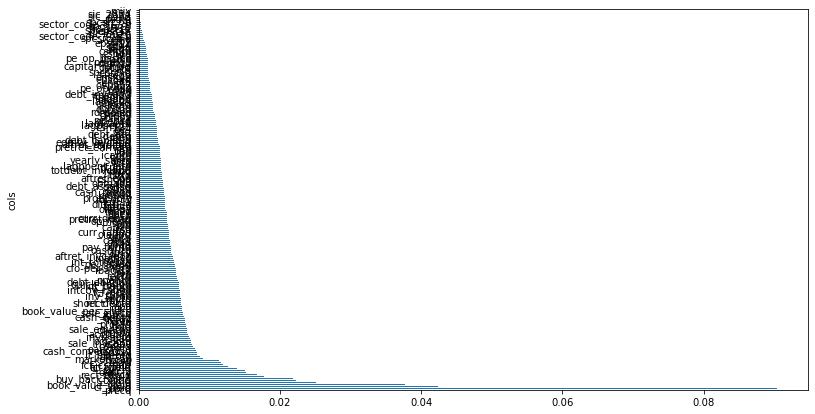

In [954]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [955]:
len(features)

190

In [956]:
bg_clf.score(train_norm,y_train)

0.5353405386858809

In [957]:
bg_clf.score(valid_norm,y_valid)

0.3749687108886108

In [958]:
pred_valid = bg_clf.predict(valid_norm)

In [959]:
Counter(pred_valid)

Counter({1: 2966, 0: 928, -1: 101})

In [960]:
Counter(y_valid)

Counter({-1: 975, 0: 1578, 1: 1442})

In [961]:
profit = (pred_valid*valid_stock_returns).sum()
profit

-115.41632800000008

In [962]:
def objective_bg(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    t_min_samples_leaf = trial.suggest_int('min_samples_leaf',100,1200,step=100)
    t_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    t_n_estimators = trial.suggest_int('n_estimators',5,50,step=5)

    
    t_clf = DecisionTreeClassifier(min_samples_leaf = t_min_samples_leaf,max_depth=t_max_depth,random_state=123)
    bg_clf = BaggingClassifier(t_clf,n_estimators=t_n_estimators,random_state=123,n_jobs=1)
    bg_clf.fit(train,labels)

    preds = bg_clf.predict(val)
    profit = (preds * val_rets).sum()

#     score = bg_clf.score(val,val_labels)

    return profit

In [963]:
study = optuna.create_study(direction="maximize")

[I 2023-01-30 00:30:30,933] A new study created in memory with name: no-name-9eb32c6d-77cb-4ed0-86f5-9d011c18ecaf


In [964]:
%%time
study.optimize(partial(objective_bg,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns.values), n_trials=50,n_jobs=-1)

[I 2023-01-30 00:31:00,666] Trial 6 finished with value: -134.1742020000001 and parameters: {'min_samples_leaf': 500, 'max_depth': 5, 'n_estimators': 5}. Best is trial 6 with value: -134.1742020000001.
[I 2023-01-30 00:31:57,252] Trial 12 finished with value: -76.9690010000001 and parameters: {'min_samples_leaf': 100, 'max_depth': 20, 'n_estimators': 5}. Best is trial 12 with value: -76.9690010000001.
[I 2023-01-30 00:32:31,169] Trial 8 finished with value: -137.54031700000007 and parameters: {'min_samples_leaf': 1000, 'max_depth': 20, 'n_estimators': 20}. Best is trial 12 with value: -76.9690010000001.
[I 2023-01-30 00:32:37,443] Trial 2 finished with value: -123.19694000000011 and parameters: {'min_samples_leaf': 300, 'max_depth': 10, 'n_estimators': 15}. Best is trial 12 with value: -76.9690010000001.
[I 2023-01-30 00:33:09,473] Trial 7 finished with value: -134.2042390000001 and parameters: {'min_samples_leaf': 400, 'max_depth': 20, 'n_estimators': 20}. Best is trial 12 with value:

CPU times: user 1h 50min 23s, sys: 1min 36s, total: 1h 52min
Wall time: 1h 46min 46s


In [965]:
study.best_params

{'min_samples_leaf': 100, 'max_depth': 10, 'n_estimators': 5}

In [966]:
t_cfl = DecisionTreeClassifier(**{'min_samples_leaf': 100, 'max_depth': 20},random_state=123)
bg_clf = BaggingClassifier(t_clf,n_estimators=10,random_state=123)

In [967]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  random_state=123)

In [968]:
pred_valid = bg_clf.predict(valid_norm)

In [969]:
bg_clf.score(train_norm,y_train)

0.4631583462000343

In [970]:
bg_clf.score(valid_norm,y_valid)

0.3732165206508135

In [971]:
confusion_matrix(pred_valid,y_valid)

array([[  21,   13,    9],
       [ 112,  411,  374],
       [ 842, 1154, 1059]])

In [972]:
#### Valid set predicted profit
(pred_valid * df_valid['next_period_return'].values).sum()

-125.88547200000008

In [973]:
fi = bagging_feat_importance(bg_clf,train_norm)

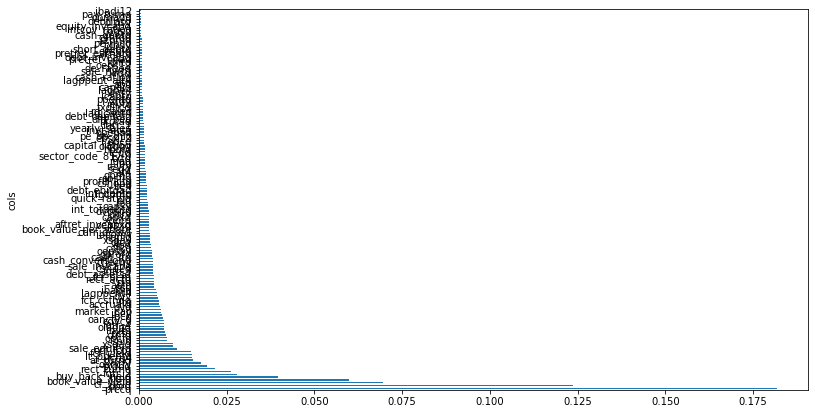

In [974]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [975]:
features

,cols,feat_imp
87,prccq,0.181666
108,dprq,0.123757
105,cf_yield,0.069695
91,book_value_yield,0.059932
89,bmq,0.039787
...,...,...
69,dltisy,0.000695
146,debt_atq,0.000689
111,opmadq,0.000644
172,pay_turnq,0.000560


In [976]:
cols = features['cols'].values


In [977]:
cols

array(['prccq', 'dprq', 'cf_yield', 'book_value_yield', 'bmq',
       'buy_back_yield', 'fqtr_2', 'rect_turnq', 'txdbq', 'oancfy',
       'at_turnq', 'lctq4', 'lt_ppentq', 'fcf_yield', 'ocf_lctq',
       'sale_equityq', 'xsgaq', 'spiq', 'opcfq', 'cfmq', 'pcfq', 'invtq',
       'oiadpq', 'fqtr_4', 'cdvcy', 'oancfy_q', 'ibcq', 'ibcy',
       'market_cap', 'dvq', 'accrualq', 'ltq', 'fcf_csfhdq', 'dvy',
       'lagppent4', 'ibadjq', 'psq', 'actq', 'piq', 'rect_actq',
       'fcf_ocfq', 'debt_assetsq', 'fqtr_3', 'csh12q', 'sale_invcapq',
       'chechy', 'cash_conversionq', 'cash_ltq', 'gprofq', 'oepsxy',
       'cstkq', 'dpq', 'dlcq', 'xsgay', 'nopiq', 'ibcomy', 'curr_debtq',
       'book_value_per_share', 'oepsxq', 'aftret_invcapxq', 'xoprq',
       'capxq', 'dltry', 'dvpspq', 'int_totdebtq', 'capxy', 'req', 'niq',
       'quick_ratioq', 'ibcomq', 'int_debtq', 'debt_ebitdaq', 'be4',
       'cshopq', 'profit_lctq', 'epsfiq', 'gpmq', 'at4', 'seqq', 'revty',
       'ibq', 'roaq', 'txtq', 'se

In [978]:
float_vars = [x for x in train[cols].columns if data[x].dtype == 'float64']
len(float_vars)

130

In [979]:
float_vars

['prccq',
 'dprq',
 'cf_yield',
 'book_value_yield',
 'bmq',
 'buy_back_yield',
 'rect_turnq',
 'txdbq',
 'oancfy',
 'at_turnq',
 'lctq4',
 'lt_ppentq',
 'fcf_yield',
 'ocf_lctq',
 'sale_equityq',
 'xsgaq',
 'spiq',
 'opcfq',
 'cfmq',
 'pcfq',
 'invtq',
 'oiadpq',
 'cdvcy',
 'oancfy_q',
 'ibcq',
 'ibcy',
 'market_cap',
 'dvq',
 'accrualq',
 'ltq',
 'fcf_csfhdq',
 'dvy',
 'lagppent4',
 'ibadjq',
 'psq',
 'actq',
 'piq',
 'rect_actq',
 'fcf_ocfq',
 'debt_assetsq',
 'csh12q',
 'sale_invcapq',
 'chechy',
 'cash_conversionq',
 'cash_ltq',
 'gprofq',
 'oepsxy',
 'cstkq',
 'dpq',
 'dlcq',
 'xsgay',
 'nopiq',
 'ibcomy',
 'curr_debtq',
 'book_value_per_share',
 'oepsxq',
 'aftret_invcapxq',
 'xoprq',
 'capxq',
 'dltry',
 'dvpspq',
 'int_totdebtq',
 'capxy',
 'req',
 'niq',
 'quick_ratioq',
 'ibcomq',
 'int_debtq',
 'debt_ebitdaq',
 'be4',
 'cshopq',
 'profit_lctq',
 'epsfiq',
 'gpmq',
 'at4',
 'seqq',
 'revty',
 'ibq',
 'roaq',
 'txtq',
 'teqq',
 'npmq',
 'oibdpy',
 'capital_ratioq',
 'dpcq',
 

In [980]:
train_red_norm = train.copy()
valid_red_norm = valid.copy()
test_red_norm = test.copy()

In [981]:
train_red_norm = pd.DataFrame(data = scaler.fit_transform(train_norm[float_vars].values),columns = float_vars)
valid_red_norm = pd.DataFrame(data = scaler.transform(valid_norm[float_vars].values),columns = float_vars)
test_red_norm = pd.DataFrame(data = scaler.transform(test_norm[float_vars].values),columns = float_vars)

# train_red_norm = scaler.fit_transform((train[cols])[float_vars])
# valid_red_norm = scaler.transform((valid[cols])[float_vars])
# test_red_norm = scaler.transform((test[cols])[float_vars])

In [982]:
len(valid_red_norm.columns)

130

In [983]:
bg_clf.fit(train_red_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  random_state=123)

In [984]:
valid_1_norm = valid_red_norm.copy()

valid_1_norm['rets'] = df_valid['next_period_return'].values

In [985]:
pred = bg_clf.predict(valid_red_norm)

In [986]:
#### Valid set predicted profit with reduced features
(pred*valid_1[valid_1_norm.columns[-1]].values).sum()

-124.29555600000008

In [987]:
def model_bg(features):
    tree_features = features[features.columns[:-1].values]

    pred = bg_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [988]:
explainer_bg = shap.explainers.Permutation(model_bg,valid_1_norm)

In [989]:
shap_values = explainer_bg(valid_1_norm,max_evals=700)

Permutation explainer: 3996it [43:52,  1.51it/s]                           


In [990]:
shap_values.values.shape 

(3995, 131)

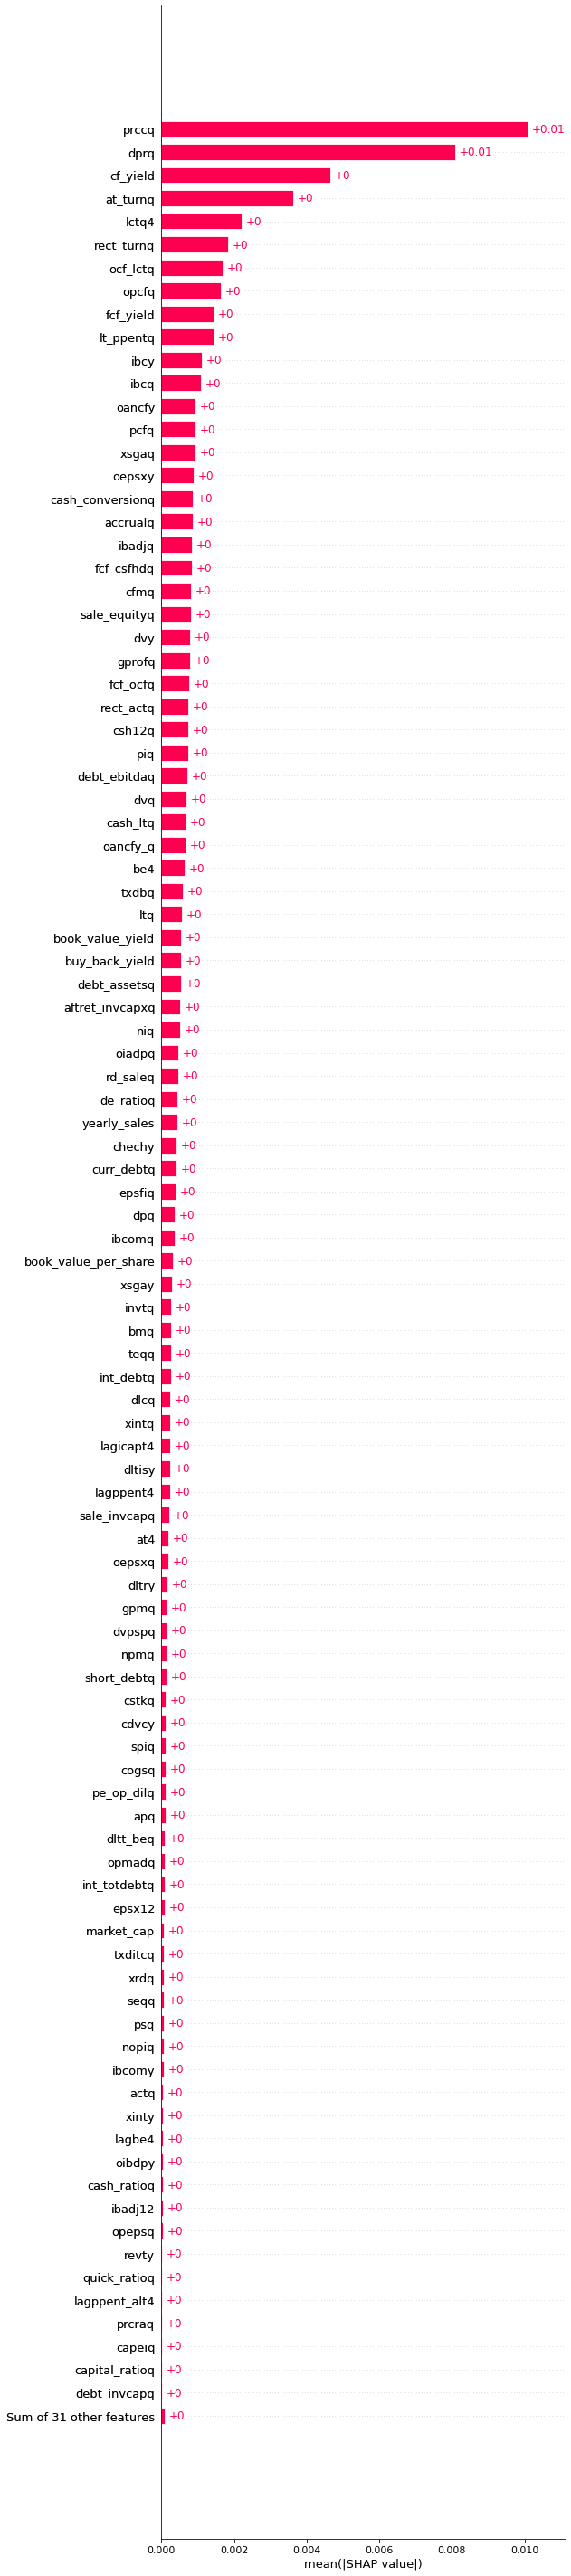

In [991]:
shap.plots.bar(shap_values[:,:-1],max_display=100,)

In [992]:
float_vars = np.array(float_vars)

In [993]:
shap_cols = float_vars[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [994]:
len(shap_cols)

122

In [995]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(32)]
end_dates = [d + pd.DateOffset(months = 11) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 11)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_outpf'].values for d in training_frames]
validation_labels = [d['rel_outpf'].values for d in test_frames]

In [996]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [997]:
x1 = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x1.append(x[i] + (x1[i]/num_names)*profit_i)

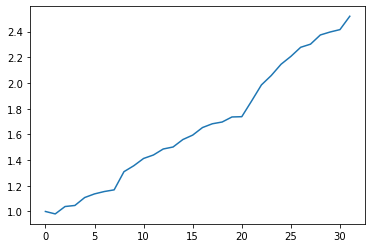

In [998]:
plt.plot(x1);

In [999]:
SPY['strategy_bg'] = x1

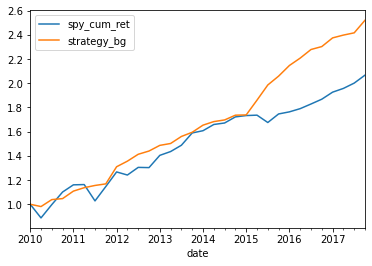

In [1000]:
SPY[['spy_cum_ret','strategy_bg']].plot();

In [1001]:
strategy_mean_ret = (SPY['strategy_bg'] - 1).diff().mean()
strategy_std = (SPY['strategy_bg'] - 1).diff().std()
strategy_bg_sr = strategy_mean_ret/strategy_std

In [1002]:
strat_bg_ret = x1[-1]

strategy_ret_bg = (SPY['strategy_bg'] - 1).diff().values[1:]

beta_bg = (np.cov(spy_ret,strategy_ret_bg)/np.var(spy_ret))[1,0]
beta_bg

0.126127634150791

In [1003]:
residual_ret_bg = strategy_ret_bg - beta_bg * spy_ret
IR_bg = np.mean(residual_ret_bg)/np.std(residual_ret_bg)
alpha_bg = np.mean(residual_ret_bg)

## Stats for Long/Short with Decision Tree vs Buy Hold SPY vs Bagging Classifier Strategy

In [1004]:
stat.loc['Stategy Bagging'] = [strategy_bg_sr, strat_bg_ret, IR_bg, alpha_bg]
stat

,Sharpe,Cum Ret,Info Ratio,Alpha
Stategy,1.616468,2.498174,1.596846,0.046789
SPY,0.575103,2.066381,0.000000,0.000000
Stategy Bagging,1.289608,2.519700,1.217544,0.044684


# 2. New Definition of Profit

In [1005]:
pred_prob = bg_clf.predict_proba(valid_red_norm)
pred_prob

array([[0.31625506, 0.27748171, 0.40626322],
       [0.27067196, 0.26543071, 0.46389733],
       [0.29332779, 0.27018717, 0.43648505],
       ...,
       [0.203108  , 0.30368049, 0.49321151],
       [0.23922309, 0.27049405, 0.49028285],
       [0.25442861, 0.31867831, 0.42689308]])

In [1006]:
len(pred_prob)

3995

In [1007]:
prob = pd.DataFrame(data= pred_prob)
prob[3] = (prob[2] - prob[0])/sum(np.abs(prob[2] - prob[0]))

np.abs(prob[3]).sum()


0.999999999999999

In [1008]:
prob 

,0,1,2,3
0,0.316255,0.277482,0.406263,0.000135
1,0.270672,0.265431,0.463897,0.000291
2,0.293328,0.270187,0.436485,0.000215
3,0.239702,0.349019,0.411278,0.000258
4,0.248968,0.309814,0.441218,0.000289
...,...,...,...,...
3990,0.181351,0.389917,0.428732,0.000372
3991,0.248324,0.331430,0.420246,0.000259
3992,0.203108,0.303680,0.493212,0.000436
3993,0.239223,0.270494,0.490283,0.000378


In [1009]:
valid_stock_returns_new =  np.array(df_valid['next_period_return'].values * prob[3])
valid_stock_returns_new

array([-4.55533348e-05, -1.56171821e-05,  9.98136535e-06, ...,
        6.20216571e-05,  2.06408772e-05,  5.91758839e-05])

In [1010]:
#### Valid set predicted profit with reduced features
(prob[3]*valid_1_norm[valid_1_norm.columns[-1]].values).sum()

-0.03141898584774411

In [1011]:
study3 = optuna.create_study(direction="maximize")

[I 2023-01-30 12:48:33,831] A new study created in memory with name: no-name-923ca7c1-68b1-48c8-87c5-002f1b4599cc


In [1012]:
%%time
study3.optimize(partial(objective,train=train_norm,labels=y_train,val=valid_norm,val_labels=y_valid,val_rets=valid_stock_returns_new), n_trials=200,n_jobs=-1)

[I 2023-01-30 12:48:42,056] Trial 10 finished with value: -0.02848416883915471 and parameters: {'min_samples_leaf': 1200, 'max_depth': 5}. Best is trial 10 with value: -0.02848416883915471.
[I 2023-01-30 12:48:42,495] Trial 6 finished with value: -0.02919238056664833 and parameters: {'min_samples_leaf': 600, 'max_depth': 5}. Best is trial 10 with value: -0.02848416883915471.
[I 2023-01-30 12:48:42,840] Trial 8 finished with value: -0.02992005893074013 and parameters: {'min_samples_leaf': 200, 'max_depth': 5}. Best is trial 10 with value: -0.02848416883915471.
[I 2023-01-30 12:48:43,113] Trial 4 finished with value: -0.027875505514466777 and parameters: {'min_samples_leaf': 1200, 'max_depth': 10}. Best is trial 4 with value: -0.027875505514466777.
[I 2023-01-30 12:48:43,613] Trial 1 finished with value: -0.027532084093467253 and parameters: {'min_samples_leaf': 1000, 'max_depth': 10}. Best is trial 1 with value: -0.027532084093467253.
[I 2023-01-30 12:48:43,705] Trial 5 finished with va

CPU times: user 46min 50s, sys: 22.8 s, total: 47min 13s
Wall time: 4min 35s


In [1013]:
study3.best_params

{'min_samples_leaf': 100, 'max_depth': 20}

In [1014]:
t_cfl = DecisionTreeClassifier(**{'min_samples_leaf': 100, 'max_depth': 25},random_state=123)
bg_clf = BaggingClassifier(t_clf,n_estimators=5,random_state=123)

In [1015]:
bg_clf.fit(train_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=5, random_state=123)

In [1016]:
pred_valid = bg_clf.predict(valid_norm)

In [1017]:
bg_clf.score(train_norm,y_train)

0.46030622748327327

In [1018]:
bg_clf.score(valid_norm,y_valid)

0.36896120150187733

In [1019]:
fi = bagging_feat_importance(bg_clf,train_norm)

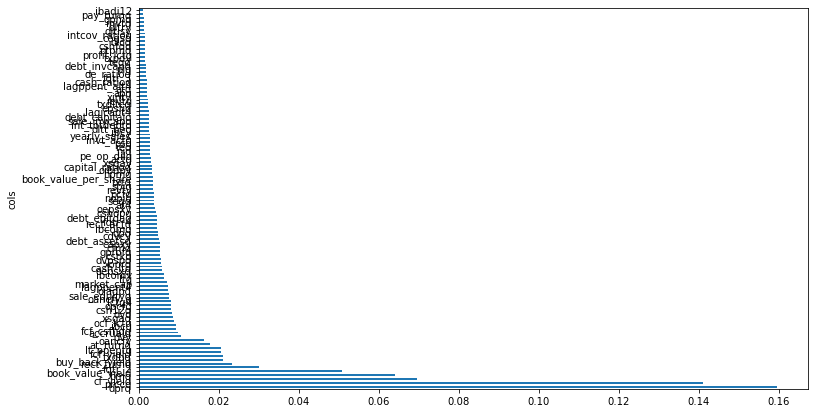

In [1020]:
features = fi[(fi['feat_imp'] > 0.0)]
plot_fi(features);

In [1021]:
features

,cols,feat_imp
108,dprq,0.159457
87,prccq,0.140963
105,cf_yield,0.069537
89,bmq,0.064037
91,book_value_yield,0.050886
...,...,...
70,dltry,0.001337
30,invtq,0.001279
112,gpmq,0.001236
172,pay_turnq,0.001120


In [1022]:
float_vars = [x for x in train[cols].columns if data[x].dtype == 'float64']
len(float_vars)

130

In [1023]:
float_vars

['prccq',
 'dprq',
 'cf_yield',
 'book_value_yield',
 'bmq',
 'buy_back_yield',
 'rect_turnq',
 'txdbq',
 'oancfy',
 'at_turnq',
 'lctq4',
 'lt_ppentq',
 'fcf_yield',
 'ocf_lctq',
 'sale_equityq',
 'xsgaq',
 'spiq',
 'opcfq',
 'cfmq',
 'pcfq',
 'invtq',
 'oiadpq',
 'cdvcy',
 'oancfy_q',
 'ibcq',
 'ibcy',
 'market_cap',
 'dvq',
 'accrualq',
 'ltq',
 'fcf_csfhdq',
 'dvy',
 'lagppent4',
 'ibadjq',
 'psq',
 'actq',
 'piq',
 'rect_actq',
 'fcf_ocfq',
 'debt_assetsq',
 'csh12q',
 'sale_invcapq',
 'chechy',
 'cash_conversionq',
 'cash_ltq',
 'gprofq',
 'oepsxy',
 'cstkq',
 'dpq',
 'dlcq',
 'xsgay',
 'nopiq',
 'ibcomy',
 'curr_debtq',
 'book_value_per_share',
 'oepsxq',
 'aftret_invcapxq',
 'xoprq',
 'capxq',
 'dltry',
 'dvpspq',
 'int_totdebtq',
 'capxy',
 'req',
 'niq',
 'quick_ratioq',
 'ibcomq',
 'int_debtq',
 'debt_ebitdaq',
 'be4',
 'cshopq',
 'profit_lctq',
 'epsfiq',
 'gpmq',
 'at4',
 'seqq',
 'revty',
 'ibq',
 'roaq',
 'txtq',
 'teqq',
 'npmq',
 'oibdpy',
 'capital_ratioq',
 'dpcq',
 

In [1024]:
train_red_norm = pd.DataFrame(data = scaler.fit_transform(train_norm[float_vars].values),columns = float_vars)
valid_red_norm = pd.DataFrame(data = scaler.transform(valid_norm[float_vars].values),columns = float_vars)
test_red_norm = pd.DataFrame(data = scaler.transform(test_norm[float_vars].values),columns = float_vars)

In [1025]:
len(valid_red_norm.columns)

130

In [1026]:
bg_clf.fit(train_red_norm,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=6,
                                                        min_samples_leaf=200),
                  n_estimators=5, random_state=123)

In [1027]:
valid_2_norm = valid_red_norm.copy()

valid_2_norm['rets'] = valid_stock_returns_new

In [1028]:
explainer_bg = shap.explainers.Permutation(model_bg,valid_2_norm)

In [1029]:
shap_values = explainer_bg(valid_2_norm,max_evals=700)

Permutation explainer: 3996it [23:55,  2.76it/s]                          


In [1030]:
shap_values.values.shape 

(3995, 131)

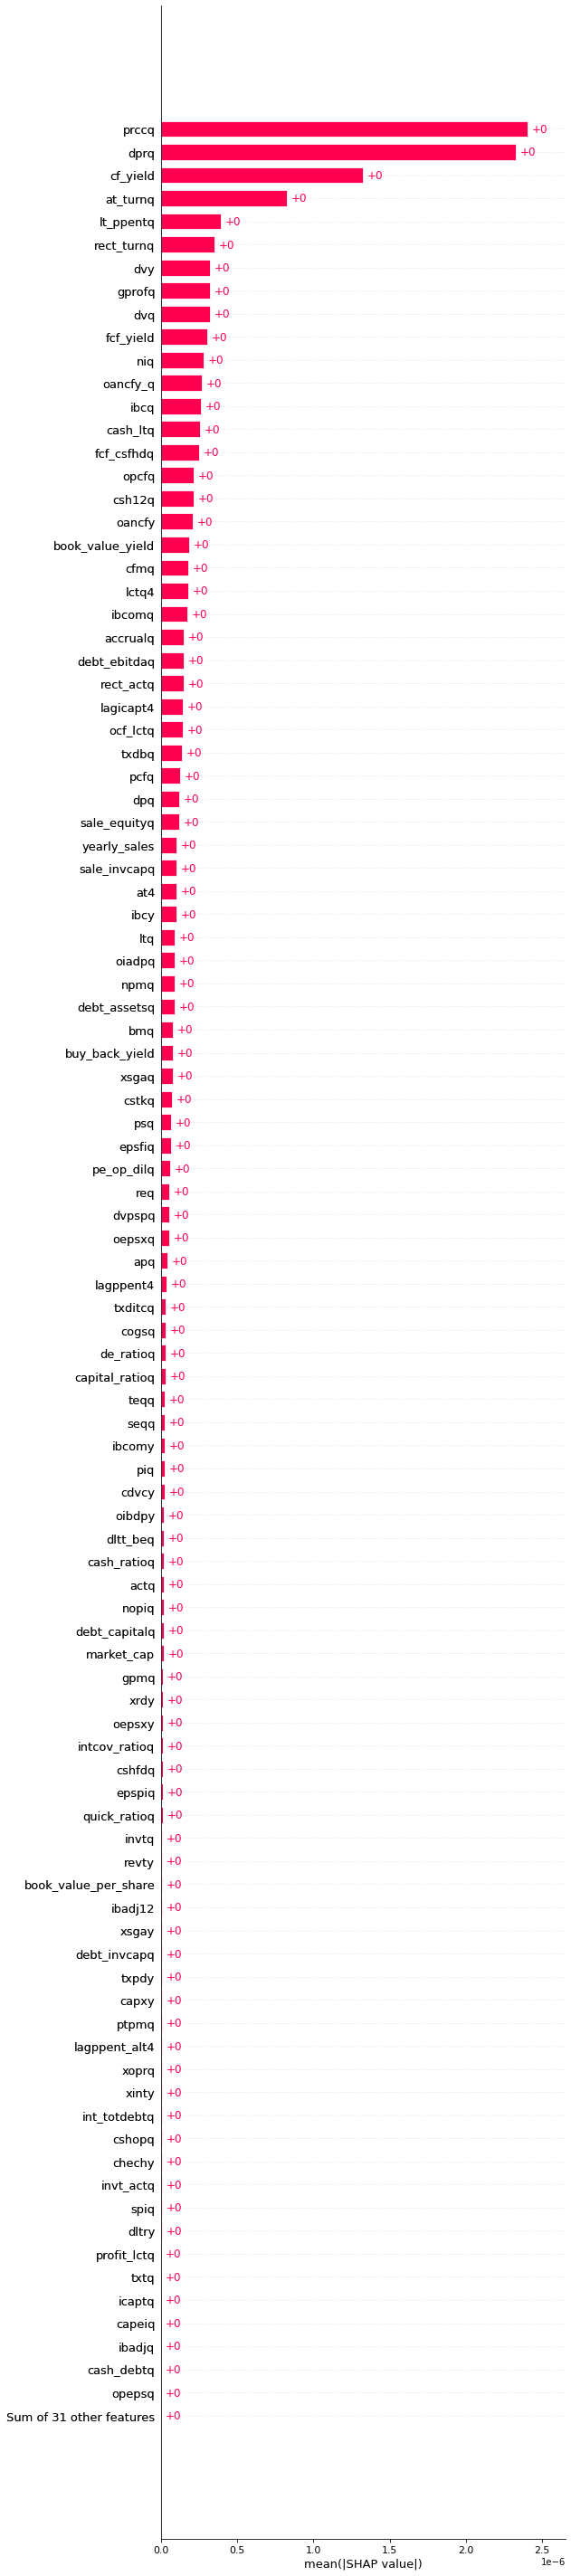

In [1031]:
shap.plots.bar(shap_values[:,:-1],max_display=100,)

In [1032]:
float_vars = np.array(float_vars)

In [1033]:
shap_cols_2 = float_vars[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]

In [1034]:
shap_cols

array(['prccq', 'dprq', 'cf_yield', 'book_value_yield', 'bmq',
       'buy_back_yield', 'rect_turnq', 'txdbq', 'oancfy', 'at_turnq',
       'lctq4', 'lt_ppentq', 'fcf_yield', 'ocf_lctq', 'sale_equityq',
       'xsgaq', 'spiq', 'opcfq', 'cfmq', 'pcfq', 'invtq', 'oiadpq',
       'cdvcy', 'oancfy_q', 'ibcq', 'ibcy', 'market_cap', 'dvq',
       'accrualq', 'ltq', 'fcf_csfhdq', 'dvy', 'lagppent4', 'ibadjq',
       'psq', 'actq', 'piq', 'rect_actq', 'fcf_ocfq', 'debt_assetsq',
       'csh12q', 'sale_invcapq', 'chechy', 'cash_conversionq', 'cash_ltq',
       'gprofq', 'oepsxy', 'cstkq', 'dpq', 'dlcq', 'xsgay', 'nopiq',
       'ibcomy', 'curr_debtq', 'book_value_per_share', 'oepsxq',
       'aftret_invcapxq', 'xoprq', 'capxq', 'dltry', 'dvpspq',
       'int_totdebtq', 'capxy', 'req', 'niq', 'quick_ratioq', 'ibcomq',
       'int_debtq', 'debt_ebitdaq', 'be4', 'cshopq', 'profit_lctq',
       'epsfiq', 'gpmq', 'at4', 'seqq', 'revty', 'ibq', 'teqq', 'npmq',
       'oibdpy', 'capital_ratioq', 'epsx

In [1035]:
len(shap_cols)

122

In [1036]:
start_dates = [pd.to_datetime('2010-01-01') + pd.DateOffset(months = 3 * i) for i in range(32)]
end_dates = [d + pd.DateOffset(months = 11) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 11)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 9)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_outpf','rel_outpf_dt','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

training_labels = [d['rel_outpf'].values for d in training_frames]
validation_labels = [d['rel_outpf'].values for d in test_frames]

In [1037]:
scalers = [StandardScaler() for _ in range(len(training_data))]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(training_data))]
opt_valid_data = [pd.DataFrame(scalers[i].transform(valid_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(valid_data))]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_cols].values),columns=shap_cols) for i in range(len(test_data))]

In [1038]:
x2 = [1]
ret = []

for i in range(len(start_dates)-1):
        t_clf.fit(opt_training_data[i],training_labels[i])

        preds = t_clf.predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x2.append(x[i] + (x1[i]/num_names)*profit_i)

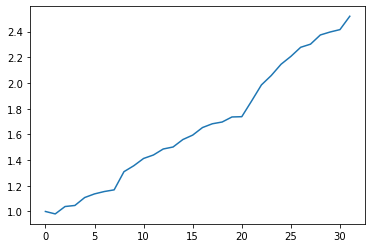

In [1039]:
plt.plot(x2);

In [1040]:
SPY['strategy_bg_new'] = x2

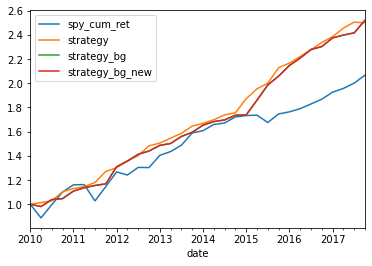

In [1041]:
SPY.plot();

In [1042]:
strategy_bg_new_mean_ret = (SPY['strategy_bg_new'] - 1).diff().mean()
strategy_bg_new_std = (SPY['strategy_bg_new'] - 1).diff().std()
strategy_bg_new_sr = strategy_bg_new_mean_ret/strategy_bg_new_std
strategy_bg_new_std 

0.03801355032152294

In [1043]:
strat_bg_new_ret = x2[-1]

strategy_ret_bg_new = (SPY['strategy_bg_new'] - 1).diff().values[1:]

beta_bg_new = (np.cov(spy_ret,strategy_ret_bg_new)/np.var(spy_ret))[1,0]
beta_bg_new

0.126127634150791

In [1044]:
residual_ret_bg_new = strategy_ret_bg_new - beta_bg_new * spy_ret
IR_bg_new = np.mean(residual_ret_bg_new)/np.std(residual_ret_bg_new)
alpha_bg_new = np.mean(residual_ret_bg_new)

### Stats for Long/Short with Decision Tree vs Buy Hold SPY vs Bagging Classifier Strategy vs New Weight Bagging Strategy

In [1045]:
stat.loc['Stategy Bagging New Weight'] = [strategy_bg_new_sr, strat_bg_new_ret, IR_bg_new, alpha_bg_new ]
stat

,Sharpe,Cum Ret,Info Ratio,Alpha
Stategy,1.616468,2.498174,1.596846,0.046789
SPY,0.575103,2.066381,0.000000,0.000000
Stategy Bagging,1.289608,2.519700,1.217544,0.044684
Stategy Bagging New Weight,1.289608,2.519700,1.217544,0.044684


The Bagging Strategy and DecisionTree Strategy perform quite similiar interm of Cummulative return and alpha. The DecisionTree Strategy has significant higher Sharpe Ratio and Information Ratio than the same ratios for Bagging Strategy. 
The new weight does not change the result from bagging strategy.

In [1]:
new = {'max_depth': 5, 'n_estimators': 30, 'learning_rate': 0.2}

In [3]:
dict(list(new.items())[1: ])

{'n_estimators': 30, 'learning_rate': 0.2}